In [1]:
IMAGE_SHAPE = (32, 32, 1)
NUM_CHANNELS = 1
NUM_EPOCH = 20
BATCH_SIZE = 100
LEARNING_RATE = 3e-5
EMBEDDING_DIM = 2

# Helper functions

In [2]:
import functools as ft

compose = lambda *fs: ft.reduce(lambda f, g: lambda x: g(f(x)), fs)

# Loading dataset

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds


def preprocess(x):
    """Process the image"""
    as_float = lambda x: tf.cast(x, tf.float32)
    scaling = lambda x: x / 255. * 2. - 1
    padding = lambda x: tf.pad(x, ((2, 2), (2, 2), (0, 0)), constant_values=-1.)
    return compose(as_float, scaling, padding)(x)


def get_dataset(num_epochs, batch_size):
    """The Fashion MNIST dataset loader"""

    train_ds = tfds.load('fashion_mnist', split='train', shuffle_files=True)
    test_ds = tfds.load('fashion_mnist', split='test')

    # Mapping images as tf tensors
    train_ds = train_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                            'label': sample['label']})
    test_ds = test_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                          'label': sample['label']})

    # TF dataloader
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

In [4]:
train_ds, test_ds = get_dataset(NUM_EPOCH, BATCH_SIZE)
assert train_ds.take(1).element_spec['image'].shape[1:] == IMAGE_SHAPE

2025-01-16 11:25:20.792007: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


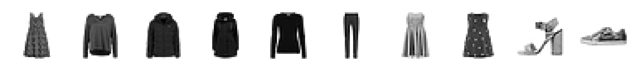

In [5]:
import matplotlib.pyplot as plt


def display(images, n=10, size=(8,6), cmap="gray_r", as_type="float32", save_to=None, style="seaborn-v0_8"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    plt.style.use(style)

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0


    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        img =  images[i]
        plt.imshow(img.astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


samples = next(train_ds.as_numpy_iterator())
display(samples['image'])

# Encoder

In [6]:
from typing import Sequence, Callable
from dataclasses import dataclass

import jax
from jax import numpy as jnp
from flax import nnx


class Encoder(nnx.Module):

    def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):

        self.layers = [
            nnx.Conv(in_features=din, out_features=32, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.gelu,
            nnx.Conv(in_features=32, out_features=32, kernel_size=(3, 3), rngs=rngs),
            nnx.gelu,
            nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.gelu,
            nnx.Conv(in_features=64, out_features=64, kernel_size=(3, 3), rngs=rngs),
            nnx.gelu,
            nnx.Conv(in_features=64, out_features=128, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.gelu,
            lambda x: x.reshape(x.shape[0], -1),
            nnx.Linear(in_features=2048, out_features=dout, rngs=rngs)
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)

# @dataclass
# class EncoderConfig:
#     din: int =  NUM_CHANNELS
#     dout: int = EMBEDDING_DIM
#     conv_filters: Sequence[int] = (32, 64, 128)
#     conv_strides: Sequence[int] = (2, 2, 2)
#     kernel_size: tuple[int] = (3, 3)
#     activation: Callable = nnx.relu


# class Encoder(nnx.Module):

#     def __init__(self, *, config: EncoderConfig, rngs: nnx.Rngs):

#         conv_features = [config.din] + list(config.conv_filters)

#         self.layers = []
#         for i in range(len(conv_features) - 1):
#             self.layers += [
#                  nnx.Conv(
#                     in_features=conv_features[i],
#                     out_features=conv_features[i+1],
#                     kernel_size=config.kernel_size,
#                     strides=config.conv_strides[i],
#                     padding="SAME",
#                     rngs=rngs
#                 ),
#                 config.activation
#             ]

#         self.layers.append(compose(jax.vmap(jnp.ravel)))
#         self.layers.append(nnx.Linear(in_features=4*4*128, out_features=config.dout, rngs=rngs))

#     def __call__(self, x: jax.Array) -> jax.Array:
#         return compose(*self.layers)(x)

In [7]:
# encoder_config = EncoderConfig()
# encoder = Encoder(config=encoder_config, rngs=nnx.Rngs(0))

encoder = Encoder(din=IMAGE_SHAPE[-1], dout=EMBEDDING_DIM, rngs=nnx.Rngs(0))
encoder(jnp.ones([BATCH_SIZE, *IMAGE_SHAPE])).shape

W0000 00:00:1736987121.003966 22005384 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1736987121.026147 22005384 service.cc:145] XLA service 0x10b31edd0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736987121.026164 22005384 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1736987121.032209 22005384 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1736987121.032234 22005384 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



(100, 2)

In [8]:
nnx.display(encoder)

Encoder(
  layers=[Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=2,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x31b0f9ee0>,
    bias_init=<function zeros at 0x168b12f20>,
    conv_general_dilated=<function conv_general_dilated at 0x168533f60>
  ), <function gelu at 0x168bfa3e0>, Conv(
    kernel_shape=(3, 3, 32, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=32,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding

# Decoder

In [9]:
class Decoder(nnx.Module):

    def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):

        self.layers = [
            nnx.Linear(in_features=din, out_features=2048, rngs=rngs),
            nnx.gelu,
            lambda x: x.reshape(x.shape[0], 4, 4, 128),
            nnx.ConvTranspose(in_features=128, out_features=64, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.gelu,
            nnx.Conv(in_features=64, out_features=64, kernel_size=(3, 3), rngs=rngs),
            nnx.gelu,
            nnx.ConvTranspose(in_features=64, out_features=32, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.gelu,
            nnx.Conv(in_features=32, out_features=32, kernel_size=(3, 3), rngs=rngs),
            nnx.gelu,
            nnx.ConvTranspose(in_features=32, out_features=dout, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.tanh
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)

# @dataclass
# class DecoderConfig:
#     din: int = EMBEDDING_DIM
#     dout: int = IMAGE_SHAPE[-1]
#     conv_filters: Sequence[int] = (128, 64, 32)
#     conv_strides: Sequence[int] = (2, 2, 2)
#     kernel_size: Sequence[int] = (3, 3)
#     activation: Callable = nnx.relu


# class Decoder(nnx.Module):

#     def __init__(self, *, config: DecoderConfig, rngs: nnx.Rngs):

#         conv_features = list(config.conv_filters) + [config.dout]


#         self.layers = [
#             nnx.Linear(in_features=config.din, out_features=4*4*128, rngs=rngs),
#             lambda x: x.reshape(x.shape[0], 4, 4, 128),
#             config.activation
#         ]

#         for i in range(len(conv_features) - 1):
#             self.layers += [
#                 nnx.ConvTranspose(
#                 in_features=conv_features[i],
#                     out_features=conv_features[i+1],
#                     kernel_size=config.kernel_size,
#                     strides=config.conv_strides[i],
#                     padding="SAME",
#                     rngs=rngs
#                 )
#             ]
#             if i+1 < len(conv_features) - 1:
#                 self.layers.append(config.activation)

#     def __call__(self, x: jax.Array) -> jax.Array:
#         return compose(*self.layers)(x)

In [10]:
# decoder_config = DecoderConfig()
# decoder = Decoder(config=decoder_config, rngs=nnx.Rngs(0))

decoder = Decoder(din=EMBEDDING_DIM, dout=IMAGE_SHAPE[-1], rngs=nnx.Rngs(0))
decoder(jnp.ones([BATCH_SIZE, EMBEDDING_DIM])).shape

(100, 32, 32, 1)

In [11]:
nnx.display(decoder)

Decoder(
  layers=[Linear(
    kernel=Param(
      value=Array(shape=(2, 2048), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(2048,), dtype=float32)
    ),
    in_features=2,
    out_features=2048,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x31b0f9ee0>,
    bias_init=<function zeros at 0x168b12f20>,
    dot_general=<function dot_general at 0x1684a4a40>
  ), <function gelu at 0x168bfa3e0>, <function Decoder.__init__.<locals>.<lambda> at 0x37388f1a0>, ConvTranspose(
    kernel_size=(3, 3),
    in_features=128,
    out_features=64,
    strides=2,
    padding='SAME',
    kernel_dilation=None,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x31b0f9ee0>,
    bias_init=<function zeros at 0x168b12f20>,
    transpose_kernel=False,
    k

# AutoEncoder

In [12]:
class AE(nnx.Module):

    def __init__(self, din: int, demb: int, dout: int, *, rngs: nnx.Rngs):
        self.encoder = Encoder(din, demb, rngs=rngs)
        self.decoder = Decoder(demb, dout, rngs=rngs)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(self.encode, self.decode)(x)

In [13]:
# encoder_config=EncoderConfig(activation=nnx.tanh); decoder_config = DecoderConfig(activation=nnx.tanh)
# model = AE(encoder_config=encoder_config, decoder_config=decoder_config, rngs=nnx.Rngs(0))

model =  AE(din=IMAGE_SHAPE[-1], demb=EMBEDDING_DIM, dout=IMAGE_SHAPE[-1], rngs=nnx.Rngs(42))
model(jnp.ones([BATCH_SIZE, *IMAGE_SHAPE])).shape

(100, 32, 32, 1)

In [14]:
nnx.display(model)

AE(
  encoder=Encoder(
    layers=[Conv(
      kernel_shape=(3, 3, 1, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=2,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x31b0f9ee0>,
      bias_init=<function zeros at 0x168b12f20>,
      conv_general_dilated=<function conv_general_dilated at 0x168533f60>
    ), <function gelu at 0x168bfa3e0>, Conv(
      kernel_shape=(3, 3, 32, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 32, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_feat

# Optimizer

In [15]:
import optax

# lr_schedule = optax.warmup_cosine_decay_schedule(
#     init_value=0.0,
#     peak_value=1e-3,
#     warmup_steps=100,
#     decay_steps=500*len(train_ds),
#     end_value=1e-5
# )
# optimizer = nnx.Optimizer(
#     model,
#     optax.chain(
#         optax.clip(1.0),  # Clip gradients at 1
#         optax.adam(lr_schedule)
#     )
# )

optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE))
metric = nnx.metrics.Average()

# Define training steps

In [16]:
def loss_fn(model: AE, batch: jax.Array):
    preds = model(batch["image"])
    loss = optax.squared_error(preds, batch["image"]).mean(axis=0).sum()
    return loss

In [17]:
@nnx.jit
def train_step(model: AE, optimizer: nnx.Optimizer, metric: nnx.Metric, batch: jax.Array):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
    loss, grads = grad_fn(model, batch)
    metric.update(values=loss)
    optimizer.update(grads)

@nnx.jit
def eval_step(model: AE, metric: nnx.Metric, batch: jax.Array):
    loss = loss_fn(model, batch)
    metric.update(values=loss)

# Train and evaluate the model

In [18]:
metric_history = {
    "train_loss": [],
    "test_loss": [],
}

num_steps_per_epoch = train_ds.cardinality() // NUM_EPOCH

for step, batch in enumerate(train_ds.as_numpy_iterator(), start=1):

    train_step(model, optimizer, metric, batch)

    if step % num_steps_per_epoch == 0:

        # Log the training metric.
        value = metric.compute()
        metric_history[f"train_loss"].append(value)  # Record the metric.
        metric.reset()  # Reset the metric for the test set.

        # Compute the metric on the test set after each training epoch.
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metric, test_batch)

        # Log the test metric.
        value = metric.compute()
        metric_history[f'test_loss'].append(value)
        metric.reset()  # Reset the metric for the next training epoch.

        print(
            f"[train] epoch: {step // num_steps_per_epoch}"
        )

        print(
            f"\ttrain loss: {metric_history['train_loss'][-1]:.4f}",
            f"\ttest_loss: {metric_history['test_loss'][-1]:.4f}"
        )


[train] epoch: 1
	train loss: 825.2299 	test_loss: 827.5854
[train] epoch: 2
	train loss: 816.3372 	test_loss: 781.5227
[train] epoch: 3
	train loss: 731.0769 	test_loss: 708.0895
[train] epoch: 4
	train loss: 706.3828 	test_loss: 693.8467
[train] epoch: 5
	train loss: 685.2762 	test_loss: 683.5820
[train] epoch: 6
	train loss: 683.2951 	test_loss: 683.5822
[train] epoch: 7
	train loss: 683.4478 	test_loss: 683.5823
[train] epoch: 8
	train loss: 679.7559 	test_loss: 679.5820
[train] epoch: 9
	train loss: 679.4828 	test_loss: 679.5821
[train] epoch: 10
	train loss: 679.2103 	test_loss: 679.5823
[train] epoch: 11
	train loss: 679.3269 	test_loss: 679.5820
[train] epoch: 12
	train loss: 654.9154 	test_loss: 651.5819
[train] epoch: 13
	train loss: 651.3704 	test_loss: 651.5821
[train] epoch: 14
	train loss: 651.4285 	test_loss: 651.5821
[train] epoch: 15
	train loss: 651.4874 	test_loss: 651.5821
[train] epoch: 16
	train loss: 651.5742 	test_loss: 651.5822
[train] epoch: 17
	train loss: 65

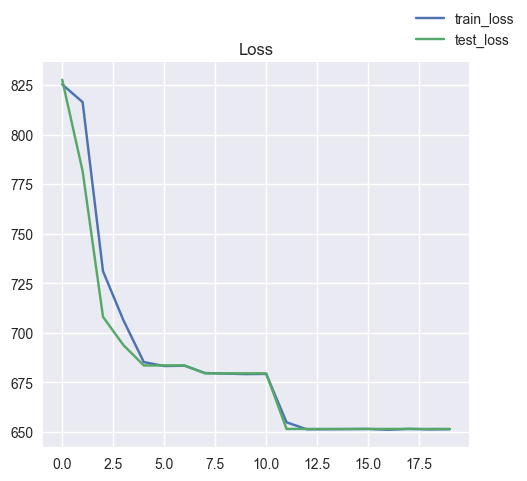

In [19]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig = plt.figure(figsize=(5.5, 5))
plt.title('Loss')
for dataset in ('train', 'test'):
    plt.plot(metric_history[f'{dataset}_loss'], label=f'{dataset}_loss')
fig.legend()
plt.show()

# Reconstruction

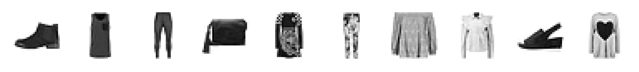

In [20]:
test_examples = test_batch['image']
display(test_examples)

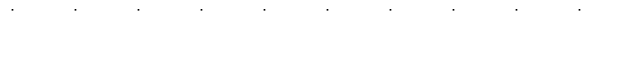

In [21]:
reconstructions = nnx.sigmoid(model(test_examples))
display(reconstructions)

# Visualising the embedding space

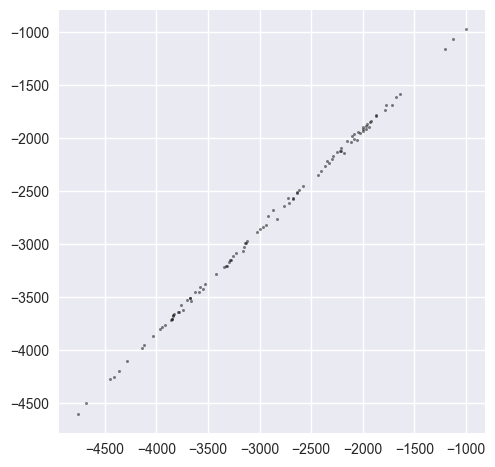

In [22]:
embeddings = model.encode(test_batch["image"])
plt.figure(figsize=(5.5, 5.5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Reconstruction

In [23]:
import numpy as np

def get_samples(ds, num_samples=10):
    example_images = []; example_labels = []
    for i, samples in enumerate(ds.as_numpy_iterator()):
        example_images.append(samples["image"])
        example_labels.append(samples["label"])

        if i * BATCH_SIZE >= num_samples:
            break
    return np.vstack(example_images)[:n_to_predict], np.hstack(example_labels)[:n_to_predict]

n_to_predict = 5_000
example_images, example_labels = get_samples(test_ds, num_samples=n_to_predict)

embeddings = model.encode(example_images)

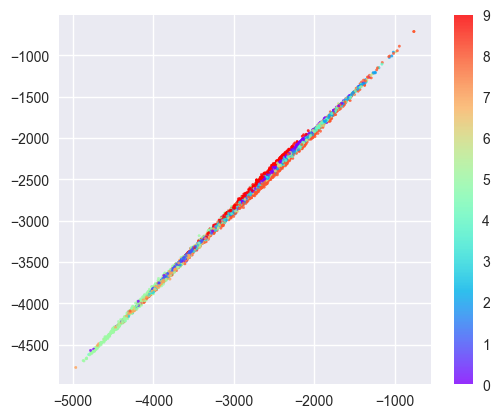

In [24]:
embeddings = model.encode(example_images)

figsize = 6
plt.figure(figsize=(figsize, figsize*0.8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## Generating new images

In [25]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (5, 2)
rnd_sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

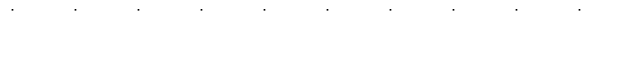

In [26]:
reconstructions = model.decode(rnd_sample).reshape(-1, *IMAGE_SHAPE)
display(reconstructions)

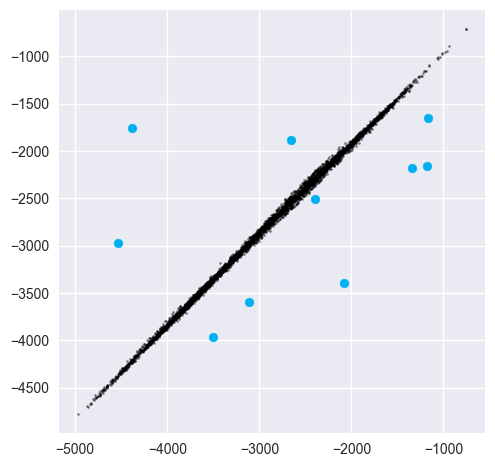

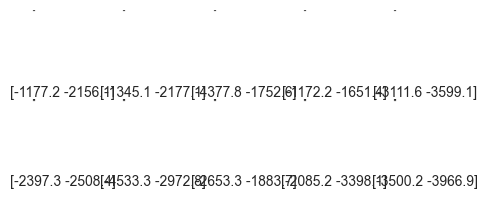

In [27]:
# Draw a plot of...
figsize = 5.5
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(rnd_sample[:, 0], rnd_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(rnd_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")